# ***Load Dataset***

In [ ]:
!rm -rf all_captions
!rm -rf all_images
!rm -rf encoded_images

In [ ]:
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip Flickr8k_Dataset.zip -d all_images
!unzip Flickr8k_text.zip -d all_captions

!rm -rf Flickr8k_Dataset.zip
!rm -rf Flickr8k_text.zip

Streaming output truncated to the last 5000 lines.
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: all_images/Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: all_images/Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: all_images/Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: all_images/Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: all_images/Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: all_images/__MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: all_images/Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: all_images/__MACOSX/Flicker8k_

# Data ***Preprocessing***

In [ ]:
image_dir = 'all_images/Flicker8k_Dataset/'
token_file = 'all_captions/Flickr8k.token.txt'

captions = open(token_file, 'r').read().strip().split('\n')

img_path = []
img_caption = []

for i in range(len(captions)):
  curr = captions[i].split('\t')
  pth = image_dir + curr[0][:-2].split('.')[0] + '.' +curr[0][:-2].split('.')[1]
  if(pth != "all_images/Flicker8k_Dataset/2258277193_586949ec62.jpg"):
    img_path.append(pth)
    img_caption.append("<start> " + curr[1].lower() + " <end>")

# ***Importing Libraries***

In [ ]:
from PIL import Image
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
import tensorflow.keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Embedding, GRU, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import time
import matplotlib.pyplot as plt

# ***Plotting Imgaes***

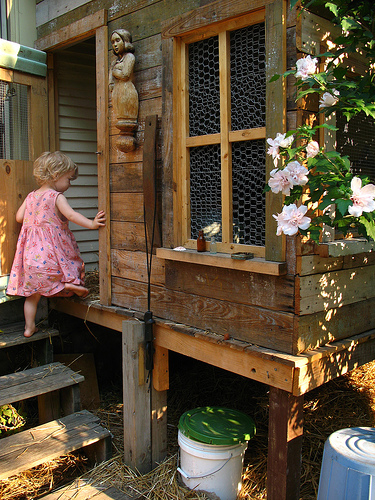

In [ ]:
img = Image.open(img_path[0])
img

In [ ]:
img_caption[0]

'<start> a child in a pink dress is climbing up a set of stairs in an entry way . <end>'

# ***Shuffling Data***

In [ ]:
img_path, img_caption = shuffle(img_path, img_caption, random_state = 1)

# ***Plotting Shuffled Data***

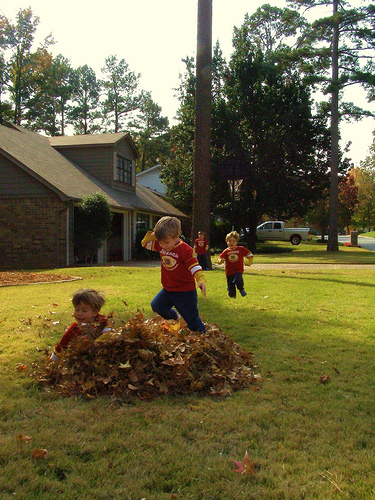

In [ ]:
img = Image.open(img_path[0])
img

In [ ]:
img_caption[0]

'<start> several children leaping into a pile of leaves on the ground . <end>'

# ***VGG-16 Model***

In [ ]:
vgg_model = VGG16(include_top = False, weights = 'imagenet')
feature_model = Model(vgg_model.input, vgg_model.layers[-1].output)

In [ ]:
feature_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

# ***Preprocessing Images***

In [ ]:
def PreProcessImage(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels = 3)
  img = tf.image.resize(img, (224, 224))
  img = preprocess_input(img)
  return img, path

In [ ]:
!rm -rf encoded_images

In [ ]:
import os
os.mkdir('./encoded_images')

In [ ]:
unique_images = sorted(set(img_path))
image_dataset = tf.data.Dataset.from_tensor_slices(unique_images)
image_dataset = image_dataset.map(PreProcessImage, num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(64)

encode_dir = "./encoded_images/"

for img, path in image_dataset:
  batch_features = feature_model(img)
  batch_features = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[-1]))

  for bf, p in zip(batch_features, path):
    image_name = p.numpy().decode('utf-8')
    img_name = image_name.split('/')[-1].split('.')[0] + '.npy'
    temp_path = encode_dir + img_name
    np.save(temp_path, bf.numpy())

# ***Text Preprocessing***

In [ ]:
top_k = 5000
tokenizer = Tokenizer(num_words = top_k, oov_token="<unk>", filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(img_caption)

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(img_caption)
cap_vector = pad_sequences(train_seqs, padding='post')

In [ ]:
cap_vector[:5]

array([[   3,  186,   63,  337,   65,    2,  521,   13,  333,    7,    6,
         171,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,   12,  595,    5,    6, 2438,  915,    6,   93,    2,
        1194,   52,    4,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,   15,   10,    8,   33,   34,    6,   25,  241,    6,
         287,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [   3,    2,   27,   12, 1503,   30,  343,    7,    2,    1,   13,
           1,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [ ]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

max_length = calc_max_length(train_seqs)

# ***Splitting into Training and Testing***

In [ ]:
img_path_train, img_path_test, img_caption_train, img_caption_test = train_test_split(img_path, cap_vector, test_size = 0.2, random_state = 0)

In [ ]:
len(img_path_train), len(img_caption_train)

(32364, 32364)

In [ ]:
len(img_path_test), len(img_caption_test)

(8091, 8091)

# ***Loading Numpy files***

In [ ]:
def LoadFeatures(img_path, caption):
  img_path = img_path.decode('utf-8')
  img_name = img_path.split('/')[-1].split('.')[0] + '.npy'
  img_features = np.load('encoded_images/' + img_name)
  return img_features, caption

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((img_path_train, img_caption_train))
dataset = dataset.map(lambda item1, item2 : tf.numpy_function(LoadFeatures, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls = tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(1000).batch(64)

# ***Encoder Model***

In [ ]:
class Encoder(Model):
  def __init__(self, Embedding_dims):
    super(Encoder, self).__init__()
    self.fc = Dense(Embedding_dims)

  def call(self, x):
    x = self.fc(x)
    # x --> (b, 49, 256)
    x = tf.nn.relu(x)
    return x

# ***Decoder Model***

In [ ]:
class LocalAttentionDecoder(Model):
  def __init__(self, units, vocab_size, Embedding_dims):
    super(LocalAttentionDecoder ,self).__init__()
    self.units = units
    self.Embedding = Embedding(vocab_size, Embedding_dims)
    self.GRU = GRU(self.units, return_sequences = True, return_state = True, recurrent_initializer = 'glorot_uniform')
    self.fc1 = Dense(self.units)
    self.Dropout = Dropout(0.5)
    self.BN = BatchNormalization()
    self.fc2 = Dense(vocab_size)

    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)


  def call(self, x, features, hidden):
    # features --> (b, 49, 256)
    # hidden --> (b, 512) 

    hidden_with_time = K.expand_dims(hidden, axis = 1)
    # hidden_with_time --> (b, 1, 512)
    attention_score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time))
    # attention_score --> (b, 49, 512)
    attention_weights = tf.nn.softmax(self.V(attention_score), axis = 1)
    # attention_weights --> (b, 49, 1)

    context_vector = attention_weights*features
    # context_vector --> (b, 39, 256)
    context_vector = tf.reduce_sum(context_vector, axis = 1)
    # context_vector --> (b, 256)

    x = self.Embedding(x)
    # x --> (b, 1, 256)

    x = K.concatenate([K.expand_dims(context_vector, axis = 1), x], axis = -1)
    # x --> (b, 1, 256+512)

    output, state = self.GRU(x)
    # output --> (b, 1, 512)
    # state --> (b, 512)

    x = self.fc1(output)
    # x --> (b, 1, 512)

    x = K.reshape(x, (-1, x.shape[2]))
    # x --> (b, 512)

    x = self.Dropout(x)
    x = self.BN(x)
    #x --> (b, 512)

    x = self.fc2(x)

    return x, state

  def reset_state(self, batch_size):
    return K.zeros((batch_size, self.units))

In [ ]:
encoder = Encoder(256)
decoder = LocalAttentionDecoder(512, 5001, 256)

In [ ]:
hidden = decoder.reset_state(16)

In [ ]:
hidden

<tf.Variable 'Variable:0' shape=(16, 512) dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [ ]:
loss_plot = []

In [ ]:
def train_step(img_tensor, target):
  loss = 0

  hidden = decoder.reset_state(batch_size = target.shape[0])

  dec_input = K.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = K.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [ ]:
num_steps = len(img_path_train) // 64

In [ ]:
EPOCHS = 32

for epoch in range(0, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                         total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.6744
Epoch 1 Batch 100 Loss 1.3806
Epoch 1 Batch 200 Loss 1.1736
Epoch 1 Batch 300 Loss 1.2883
Epoch 1 Batch 400 Loss 1.0432
Epoch 1 Batch 500 Loss 1.0971
Epoch 1 Loss 1.296069
Time taken for 1 epoch 443.85796785354614 sec

Epoch 2 Batch 0 Loss 0.9486
Epoch 2 Batch 100 Loss 0.9783
Epoch 2 Batch 200 Loss 1.0950
Epoch 2 Batch 300 Loss 1.0248
Epoch 2 Batch 400 Loss 1.0018
Epoch 2 Batch 500 Loss 0.9358
Epoch 2 Loss 0.995085
Time taken for 1 epoch 441.60903787612915 sec

Epoch 3 Batch 0 Loss 0.8944
Epoch 3 Batch 100 Loss 0.9101
Epoch 3 Batch 200 Loss 0.8918
Epoch 3 Batch 300 Loss 0.8959
Epoch 3 Batch 400 Loss 0.8951
Epoch 3 Batch 500 Loss 0.8185
Epoch 3 Loss 0.895030
Time taken for 1 epoch 437.58352065086365 sec

Epoch 4 Batch 0 Loss 0.7570
Epoch 4 Batch 100 Loss 0.8491


KeyboardInterrupt: ignored

In [ ]:
encoder.load_weights("./gdrive/My Drive/encoder2.hdf5")
decoder.load_weights("./gdrive/My Drive/decoder2.hdf5")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


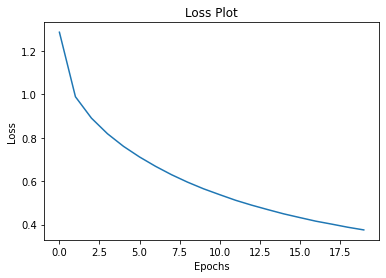

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
def evaluate(image):

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(PreProcessImage(image)[0], 0)
    img_tensor_val = feature_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden = decoder(dec_input, features, hidden)


        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result

        dec_input = tf.expand_dims([predicted_id], 0)

    return result

In [ ]:
rid = np.random.randint(0, len(img_path_test))
image = img_path_test[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in img_caption_test[rid] if i not in [0]])
result =  evaluate(image)

In [ ]:
real_caption

'<start> two young boys one white and one black are standing with their arms around each other <end>'

In [ ]:
result

['two',
 'boys',
 'one',
 'white',
 'haired',
 'male',
 'one',
 'white',
 'dog',
 'wearing',
 'blue',
 'halter',
 'top',
 'and',
 'a',
 'boy',
 'in',
 'pink',
 'top',
 'and',
 'one',
 'white',
 'school',
 'skirts',
 'pose',
 '<end>']

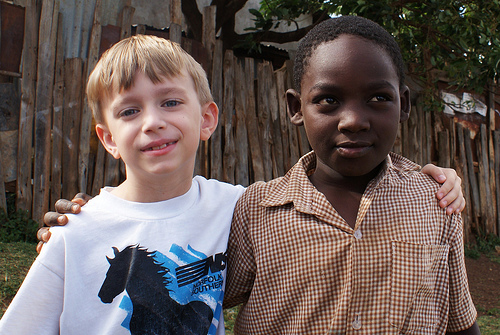

In [ ]:
Image.open(image)

In [ ]:
import pickle

In [ ]:
with open("./gdrive/My Drive/tokenizer.pkl", 'wb') as f:
  pickle.dump(tokenizer, f, protocol = pickle.HIGHEST_PROTOCOL)